# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Технологический процесс


Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.
Описание данных


Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


Наименование признаков


Наименование признаков должно быть такое:


[этап].[тип_параметра].[название_параметра]


Пример: rougher.input.feed_ag


Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

Данные находятся в трёх файлах:
- gold_recovery_train.csv — обучающая выборка;
- gold_recovery_test.csv — тестовая выборка;
- gold_recovery_full.csv — исходные данные.


Данные индексируются датой и временем получения информации (признак date). 
Соседние по времени параметры часто похожи.


Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.


Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.


# 1. Подготовка данных

#### 1.1. Откройте файлы и изучите их.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('../work/data/gold_recovery_train.csv', index_col='date', parse_dates=True)
test = pd.read_csv('../work/data/gold_recovery_test.csv', index_col='date', parse_dates=True)
full = pd.read_csv('../work/data/gold_recovery_full.csv', index_col='date', parse_dates=True)

Проверим как исходный датасет разделён на обучающую и тестовую выборки.

In [3]:
train.shape, test.shape, full.shape

((16860, 86), (5856, 52), (22716, 86))

In [4]:
len(train) + len(test) - len(full)

0

In [5]:
len(train) / len(full), len(test) / len(full)

(0.7422081352350766, 0.2577918647649234)

Соотношение обучающей и тестовой примерно 75 и 25%

In [6]:
train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [7]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [9]:
for i in train, test, full:
    print(i.info())
    print()
    print('-------------------------------------------------------------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

---

#### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака 'rougher.output.recovery'. Найдите MAE между вашими расчётами и значением признака.

Т.к. предобработку данных мы ещё не делали, для расчёта эффективность обогащения создадим тестовый датафрейм и удалим все пропуски.

In [10]:
test_train = train.dropna()

Эффективность обогащения рассчитывается по формуле:

Recovery = (C*(F-T)/F*(C-T))*100%

где:
 * C — доля золота в концентрате после флотации/очистки; (**rougher.output.concentrate_au**)
 * F — доля золота в сырье/концентрате до флотации/очистки; (**rougher.input.feed_au**)
 * T — доля золота в отвальных хвостах после флотации/очистки. (**rougher.output.tail**)


In [11]:
def recovery(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    
    rec = ((C*(F-T))/(F*(C-T)))*100
    return rec

In [12]:
test_train['recovery'] = test_train.apply(recovery, axis=1)

<ipython-input-12-8f3e4776ffe0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_train['recovery'] = test_train.apply(recovery, axis=1)


In [13]:
test_train[['rougher.output.recovery','recovery']].describe()

,rougher.output.recovery,recovery
count,11017.000000,11017.000000
mean,82.741888,82.741888
std,13.590523,13.590523
min,0.000000,-0.000000
25%,79.997468,79.997468
50%,84.847754,84.847754
75%,89.635149,89.635149
max,100.000000,100.000000


In [14]:
test_train[(test_train['rougher.output.recovery'] - test_train['recovery']) > 0.00000000000001][['rougher.output.recovery','recovery']]

,rougher.output.recovery,recovery
date,,
2016-01-15 06:00:00,88.168065,88.168065
2016-01-15 10:00:00,88.280699,88.280699
2016-01-15 11:00:00,88.499117,88.499117
2016-01-15 14:00:00,87.235441,87.235441
2016-01-15 15:00:00,85.136294,85.136294
...,...,...
2018-08-17 16:59:59,90.384753,90.384753
2018-08-17 20:59:59,90.577495,90.577495
2018-08-18 04:59:59,90.677361,90.677361


Разница в 0.00000000000001. Эффективность обогащения рассчитана правильно.

Найдите MAE между вашими расчётами и значением признака.

In [15]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_train['rougher.output.recovery'], test_train['recovery'])

In [16]:
print('mae=%.20f' % (mae))

mae=0.00000000000000955560


Средняя абсолютная ошибка очень мала, эффективность обогащения рассчитана правильно.

----

#### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [17]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

1) В тестовой выборке отсутствуют целевые признаки:
    
 * эффективность обогащения чернового концентрата **rougher.output.recovery**
 * эффективность обогащения финального концентрата **final.output.recovery**
 
Необходимо целевые признаки заполнить из full выборки, т.к. необходимо будет проверить модель после обучение.

2) В тестовой выборке отброшены столбцы с финальным этапом (**final**), данный шаг правильный т.к. данные признаки становятся известны позже. В предобработке данных удалим данные столбцы из обучающей выборки.

3) В тестовой выборке отсутвуют столбцы с данными с расчётными данными rougher.output и rougher.calculation и secondary_cleaner.output данные становятся ивестны позже. В предобработке данных удалим данные столбцы из обучающей выборки.

---

#### 1.4. Проведите предобработку данных.

##### Обучающая выборка. train

In [18]:
train.isna().sum()

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

Выявлены пустые строки в столбцах с целевым признаком. Необходимо избавляться от них.


В обучающей выборке очень много пустых, значений. В реальной задаче необходимо более детально обследовать данной проблемы. 

Т.к. в информации мы ограничены, удалим все пустые значения.

Лучше удалить пустые значения. Чем заполнять непонятно какими данными.

In [19]:
train.shape[0]

16860

In [20]:
train.dropna(inplace=True);

In [21]:
train.shape[0]

11017

5000 сток мы потеряли. Для обучающей выборки осталось более 11тыс. строк. Данных потерянно много, но мы исключаем ошибку не правильного заполнения пустых строк.

Необходимо удалить лишние столбцы для последующего обучения. Кроме целевых признаков('rougher.output.recovery', 'final.output.recovery')

In [22]:
#Список ненужных столбцов для обучения
droplist = ((set(train.columns) - set(test.columns))) - set(['rougher.output.recovery', 'final.output.recovery'])
droplist

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

In [23]:
train.drop(labels=droplist, axis=1, inplace=True)

In [24]:
train.shape

(11017, 54)

In [25]:
train.duplicated().sum()

0

In [26]:
train[['rougher.output.recovery','final.output.recovery']].describe()

,rougher.output.recovery,final.output.recovery
count,11017.000000,11017.000000
mean,82.741888,66.808219
std,13.590523,8.821074
min,0.000000,0.000000
25%,79.997468,62.955190
50%,84.847754,67.319742
75%,89.635149,72.060933
max,100.000000,100.000000


---

##### Тестовая выборка test.

Необходимо добавить целевые признаки из full выборки.

In [27]:
test = test.merge(full[['rougher.output.recovery','final.output.recovery']], on=['date'],how='left')

In [28]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


In [29]:
test.isna().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


In [30]:
#Удалим пустые значения.
test.dropna(inplace=True)

In [31]:
test.duplicated().sum()

0

---

##### Полная выборка full.

Удалим все пропуски, подобно тестовой и обучающей выборки.

In [32]:
full.dropna(inplace=True)

In [33]:
test.duplicated().sum()

0

----

In [34]:
train.shape[0], test.shape[0]

(11017, 5229)

Соотношение тестовой и обучающей выборок поменялось: 1:2.

-----

Вывод


- Данные были рассмотрены и изучены.
- Т.к. у нас много данных мы избавились от строк с пустыми значениями. 
- В тестовой выборке добавили целевые признаки.


# 2. Анализ данных

#### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

In [35]:
au = full[['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
au.columns = ['После флотации', 'После первичной очистки', 'После вторичной очистки']
au = au.sum()
ag = full[['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
ag.columns = ['После флотации', 'После первичной очистки', 'После вторичной очистки']
ag = ag.sum()
pb = full[['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]
pb.columns = ['После флотации', 'После первичной очистки', 'После вторичной очистки']
pb = pb.sum()



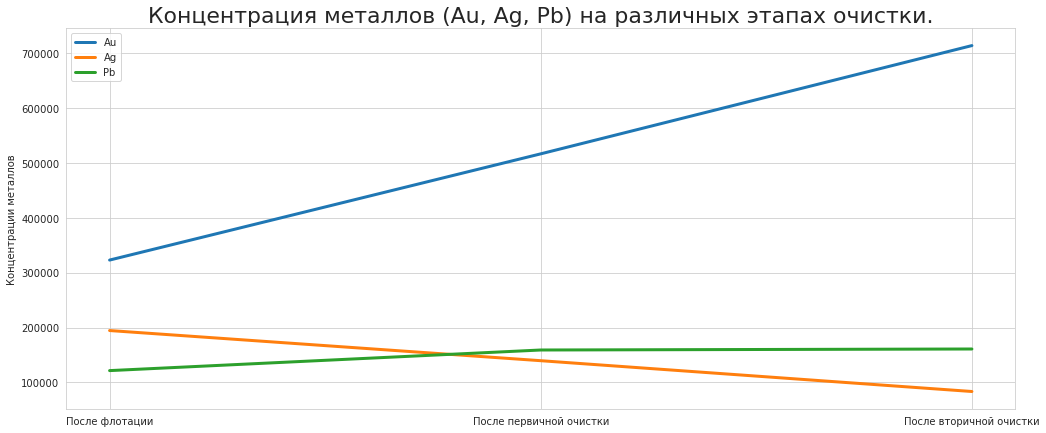

In [36]:

fig = plt.figure(figsize=(17, 7))
sns.set_style('whitegrid')
sns.lineplot(data=au, label = 'Au', sort=False, lw=3)
sns.lineplot(data=ag, label = 'Ag', sort=False, lw=3)
sns.lineplot(data=pb, label = 'Pb', sort=False, lw=3)

plt.title('Концентрация металлов (Au, Ag, Pb) на различных этапах очистки.', fontsize =22)
plt.ylabel('Концентрации металлов')
plt.show()

Концентрация металлов с каждым этапом очиски измененяется:
- Концентрация золота значительно увеличивается.
- Доля серебра уменьшается.
- Доля свинца после флотации увеличивается, далее остается такой же, или немного увеличивается.


#### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


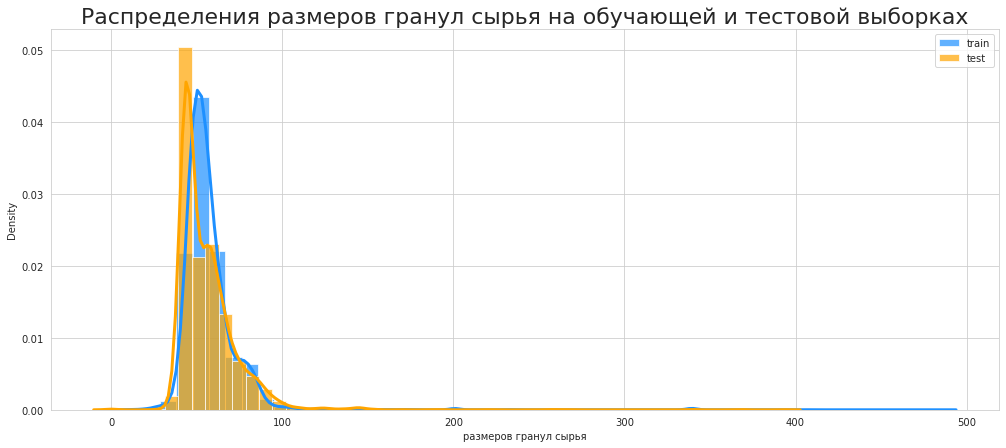

In [37]:
fig = plt.figure(figsize=(17, 7))
sns.set_style('whitegrid')
sns.distplot(train['rougher.input.feed_size'], color="dodgerblue", label="train", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(test['rougher.input.feed_size'], color="orange", label="test", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})

plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках', fontsize =22)
plt.xlabel('размеров гранул сырья')
plt.legend()
plt.show()

In [38]:
(train['rougher.input.feed_size']).describe() ,(test['rougher.input.feed_size']).describe()


(count    11017.000000
 mean        57.215128
 std         18.913146
 min          9.659576
 25%         48.397242
 50%         53.843359
 75%         61.461770
 max        484.967466
 Name: rougher.input.feed_size, dtype: float64,
 count    5229.000000
 mean       55.863978
 std        18.914656
 min         0.046369
 25%        43.911874
 50%        50.772729
 75%        62.265394
 max       392.494040
 Name: rougher.input.feed_size, dtype: float64)

Визуально распределения отличаются не сильно, оценка модели должна быть верной. 


Однако, проверим применима ли на данном этапе проверка гипотез. 

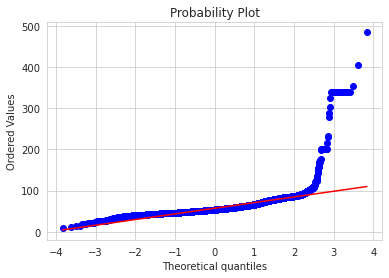

In [39]:
# Проверка распределения на нормальность. 
import pylab
import scipy.stats as stats

stats.probplot(train['rougher.input.feed_size'], dist = "norm",plot=pylab)

pylab.show()

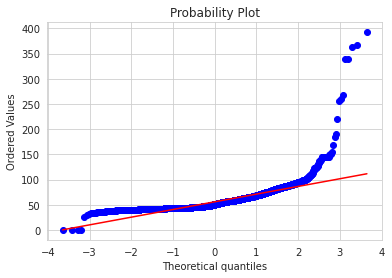

In [40]:
stats.probplot(test['rougher.input.feed_size'], dist = "norm",plot=pylab)
pylab.show()

Оба распределения не являются нормальными, применим U-критерий Манна-Уитни.

Нулевая гипотеза звучит так: распределения одинаковые, альтернативная гипотеза ей противоположна: распределения отличаются друг от друга.

alpha возьмём 0.05

In [41]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(train['rougher.input.feed_size'], test['rougher.input.feed_size'],alternative='two-sided')
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Statistics=32890944.000, p-value=0.000
Отвергаем нулевую гипотезу


На графике распределения размеров гранул сырья не сильно отличаются, но p-value ниже уровня значимости. Назвать их одинаковыми нельзя. Исключать этого признак из выборки мы не будем, за недостатком информации. В реальной задаче требуется уточнение, по данному шагу.

---

#### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

Определим стадии веществ которые нам нужны:



**final.output** Финальный концентрат
- 'final.output.concentrate_ag',
- 'final.output.concentrate_pb',
- 'final.output.concentrate_sol',
- 'final.output.concentrate_au',

 
**primary_cleaner** После очистки
- 'primary_cleaner.output.concentrate_ag',
- 'primary_cleaner.output.concentrate_pb',
- 'primary_cleaner.output.concentrate_sol',
- 'primary_cleaner.output.concentrate_au',


**rougher.output** Черновая смесь
- 'rougher.output.concentrate_ag',
- 'rougher.output.concentrate_pb',
- 'rougher.output.concentrate_sol',
- 'rougher.output.concentrate_au',

Интересный элемент sol, требуется уточнение у постановщика задачи по этому поводу. Предположим это примеси соли для очищения руды.

In [42]:
full['final.output.concentrate'] = (full['final.output.concentrate_ag']
                                    + full['final.output.concentrate_pb']
                                    + full['final.output.concentrate_sol']
                                    + full['final.output.concentrate_au'])


full['primary_cleaner.output.concentrate'] = (full['primary_cleaner.output.concentrate_ag']
                                              + full['primary_cleaner.output.concentrate_pb']
                                              + full['primary_cleaner.output.concentrate_sol']
                                              + full['primary_cleaner.output.concentrate_au'])


full['rougher.output.concentrate'] = (full['rougher.output.concentrate_ag']
                                      + full['rougher.output.concentrate_pb']
                                      + full['rougher.output.concentrate_sol']
                                      + full['rougher.output.concentrate_au'])

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

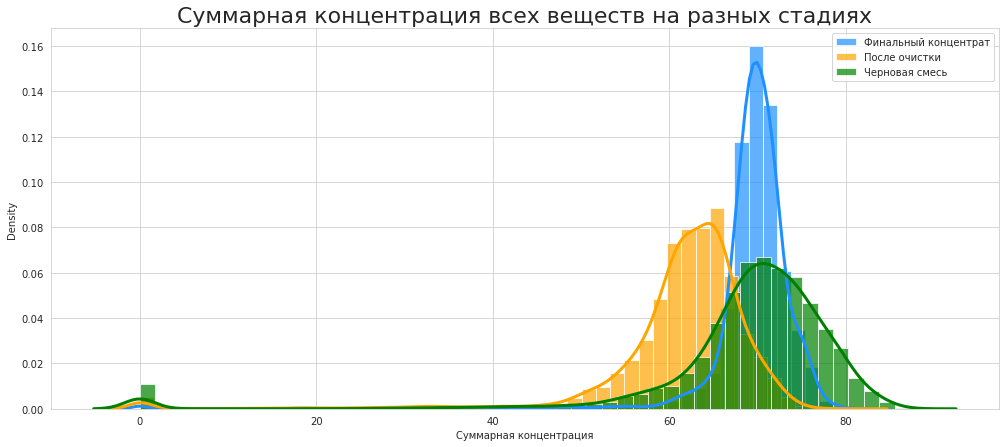

In [43]:
fig = plt.figure(figsize=(17, 7))
sns.set_style('whitegrid')
sns.distplot(full['final.output.concentrate'], color="dodgerblue", label="Финальный концентрат", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(full['primary_cleaner.output.concentrate'], color="orange", label="После очистки", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(full['rougher.output.concentrate'], color="g", label="Черновая смесь", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})

plt.title('Суммарная концентрация всех веществ на разных стадиях', fontsize=22)
plt.xlabel('Суммарная концентрация')
plt.legend()
plt.show()

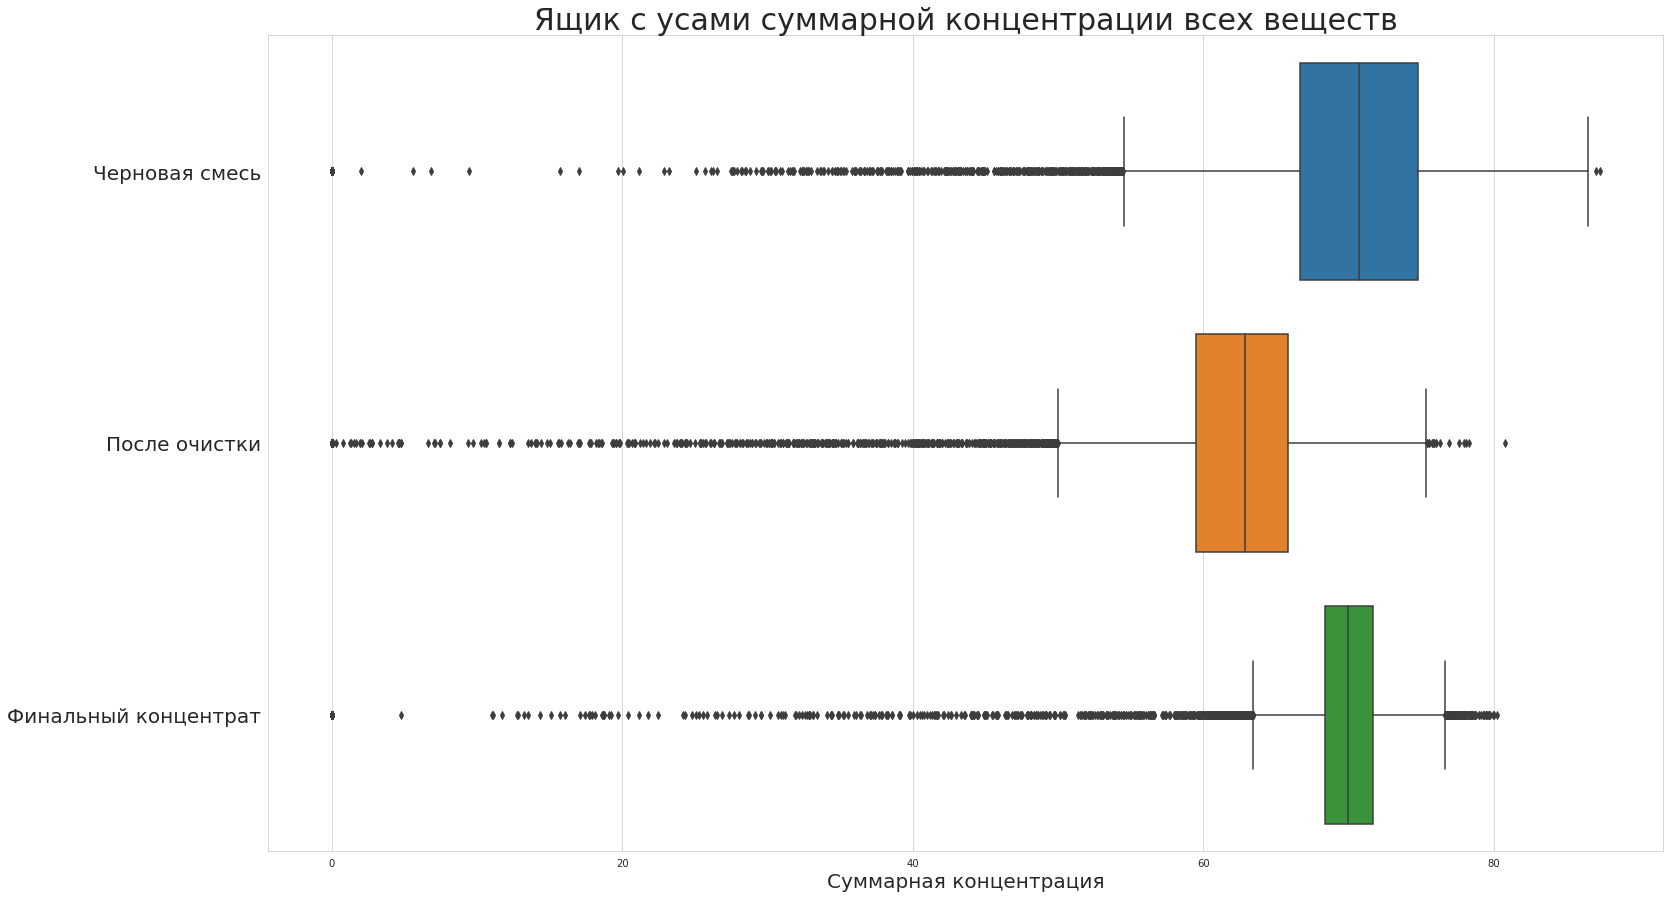

In [44]:
plt.figure(figsize=(25, 15))
sns.boxplot(data=full[['rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']]
            ,orient='h')
plt.title('Ящик с усами суммарной концентрации всех веществ', fontsize=30)
plt.xlabel('Суммарная концентрация', fontsize=20)
plt.yticks(np.arange(3), ('Черновая смесь', 'После очистки', 'Финальный концентрат'), fontsize=20)
plt.show()

In [45]:
full[['rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']].describe()

,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
count,16094.000000,16094.000000,16094.000000
mean,68.805821,61.372275,69.367841
std,12.095202,9.099059,6.038211
min,0.000000,0.000000,0.000000
25%,66.643291,59.478815,68.372986
50%,70.701213,62.838238,69.943177
75%,74.763404,65.819924,71.669414
max,87.273435,80.749343,80.210644


Без консультации постановщика задач, трудно делать однозначные выводы.


Мы наблюдаем множество выбросов, логика подсказывает удалить выбросы совсем. Но, абсолютно аномальными выглядят значения финального сырья близкие к нулю. Удалим их с тестовой и обучающей выборки.

In [46]:
test.shape, train.shape

((5229, 54), (11017, 54))

In [47]:
test = test[test.index.isin(full[full['final.output.concentrate'] > 0].index)]
train = train[train.index.isin(full[full['final.output.concentrate'] > 0].index)]

In [48]:
test.shape, train.shape

((5065, 54), (10988, 54))

#### Вывод

- Мы рассмотрели, как меняется концентрация металла с каждым этапом очистки. Выяснили что концентрация золота значительно увеличивается, для серебра уменьшается, а свинец после флотации увеличивается, далее остается такой же, или немного увеличивается.

- Выяснили распределения размеров гранул сырья не сильно отличаются. Наводит на мысль что данные были распределены не случайно.

- Рассмотрели суммарные концентрации веществ на разных этапах процесса. Обнаружили аномально низкие значения, близкие к нулю. Избавились от нулевых значений.


Как итог: не понятно, зачем было разделять основную выборку на обучающую и тестовую до обработки данных. 

# 3. Модель

#### 3.1. Напишите функцию для вычисления итоговой sMAPE.

эффективность обогащения чернового концентрата rougher.output.recovery
эффективность обогащения финального концентрата final.output.recovery

In [49]:
def smape(target, predictions):
    smape = 100/len(target) * np.sum(2* np.abs(target-predictions) / (np.abs(target) + np.abs(predictions)))
    return smape

In [50]:
def total_sMape(rougher, final):
    total_sMape = 0.25*rougher + 0.75*final
    return total_sMape

---

#### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке.

Добавим нашу метрику, по которой будем считать scoring. Т.к. нам необходимо минимизировать значение метрики умножим на -1. Применив greater_is_better=False

In [51]:
score_smape = make_scorer(smape, greater_is_better=False)

In [52]:
#Обучающие признаки и целевые признаки

target_train_rougher = train['rougher.output.recovery']
features_train_rougher = train.drop(['rougher.output.recovery','final.output.recovery'],axis=1)

target_test_rougher = test['rougher.output.recovery']
features_test_rougher = test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)

In [53]:
target_train_final = train['final.output.recovery']
features_train_final = train.drop(['rougher.output.recovery','final.output.recovery'],axis=1)

target_test_final = test['final.output.recovery']
features_test_final = test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)

#### LinearRegression

In [54]:
#Создаём распределение параметров
rs_params_LinearRegression = {'fit_intercept' : [True, False],
                              'normalize' : [True, False],}

In [55]:
#Создаём GridSearchCV
LinearRegression = GridSearchCV(LinearRegression(),
                                param_grid = rs_params_LinearRegression,
                                cv=5, 
                                scoring = score_smape)

In [56]:
#Обучаем rougher
LinearRegression.fit(features_train_rougher, target_train_rougher)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False))

In [57]:
#проверяем на тесте rougher
LinearRegression_rougher = smape(target_test_rougher, LinearRegression.predict(features_test_rougher))

In [58]:
#Обучаем final
LinearRegression.fit(features_train_final, target_train_final)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(smape, greater_is_better=False))

In [59]:
#проверяем на тесте final
LinearRegression_final = smape(target_test_final, LinearRegression.predict(features_test_final))

In [60]:
# Итоговая метрика LinearRegression проверенная на тесте
total_sMape(LinearRegression_rougher, LinearRegression_final)

8.160324637358332

In [61]:
general_table = {}

In [62]:
general_table.update({"LinearRegression":total_sMape(LinearRegression_rougher, LinearRegression_final)})

-----

#### DecisionTreeRegressor

In [63]:
#Создаём распределение параметров
rs_params_DecisionTreeRegressor = {'max_depth': range(1, 11)}

In [64]:
#Создаём GridSearchCV
DecisionTreeRegressor_ = GridSearchCV(DecisionTreeRegressor(random_state=12345)
                                        , param_grid = rs_params_DecisionTreeRegressor
                                        , cv=5
                                        , scoring = score_smape)

In [65]:
#Обучаем rougher
DecisionTreeRegressor_.fit(features_train_rougher, target_train_rougher)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 11)},
             scoring=make_scorer(smape, greater_is_better=False))

In [66]:
#проверяем на тесте rougher
DecisionTreeRegressor_rougher = smape(target_test_rougher, DecisionTreeRegressor_.predict(features_test_rougher))

In [67]:
#Обучаем final
DecisionTreeRegressor_.fit(features_train_final, target_train_final)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 11)},
             scoring=make_scorer(smape, greater_is_better=False))

In [68]:
#проверяем на тесте final
DecisionTreeRegressor_final = smape(target_test_final, DecisionTreeRegressor_.predict(features_test_final))

In [69]:
# Итоговая метрика DecisionTreeRegressor проверенная на тесте
total_sMape(DecisionTreeRegressor_rougher, DecisionTreeRegressor_final)

8.683219819948485

In [70]:
general_table.update({"DecisionTreeRegressor":total_sMape(DecisionTreeRegressor_rougher, DecisionTreeRegressor_final)})

----

#### RandomForestRegressor

Ограничил n_iter на 2,  для экономии времени.

In [71]:
rs_params_RandomForestRegressor = {'max_depth': range(1,11),
                                  'n_estimators': range(10, 100, 10)}

In [72]:
RandomForestRegressor_ = RandomizedSearchCV(RandomForestRegressor(random_state=12345),
                                            param_distributions=rs_params_RandomForestRegressor,
                                            cv=5,
                                            scoring=score_smape, 
                                            n_iter=30)

In [73]:
%%time
RandomForestRegressor_.fit(features_train_rougher, target_train_rougher) 

CPU times: user 19min 57s, sys: 837 ms, total: 19min 58s
Wall time: 19min 58s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   n_iter=30,
                   param_distributions={'max_depth': range(1, 11),
                                        'n_estimators': range(10, 100, 10)},
                   scoring=make_scorer(smape, greater_is_better=False))

In [74]:
RandomForestRegressor_.best_params_

{'n_estimators': 90, 'max_depth': 3}

In [75]:
#проверяем на тесте rougher
RandomForestRegressor_rougher = smape(target_test_rougher, RandomForestRegressor_.predict(features_test_rougher))

In [76]:
#Обучаем final
RandomForestRegressor_.fit(features_train_final, target_train_final)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   n_iter=30,
                   param_distributions={'max_depth': range(1, 11),
                                        'n_estimators': range(10, 100, 10)},
                   scoring=make_scorer(smape, greater_is_better=False))

In [77]:
RandomForestRegressor_.best_params_

{'n_estimators': 40, 'max_depth': 1}

In [78]:
#проверяем на тесте final
RandomForestRegressor_final = smape(target_test_final, RandomForestRegressor_.predict(features_test_final))

In [79]:
# Итоговая метрика DecisionTreeRegressor проверенная на тесте
total_sMape(RandomForestRegressor_rougher, RandomForestRegressor_final)

8.445281132055749

In [80]:
general_table.update({"RandomForestRegressor":total_sMape(RandomForestRegressor_rougher, RandomForestRegressor_final)})

---

#### Значения по среденему.

Для проверки наших моделей, заполним качество пресказаний из средних значений. 

In [81]:
mean_rougher = smape(target_train_rougher, target_train_rougher.mean())

In [82]:
mean_final = smape(target_test_final, target_test_final.mean())

In [84]:
# Итоговая метрика среднего значения проверенная на тесте
total_sMape(mean_rougher, mean_final)

8.226379162121479

---

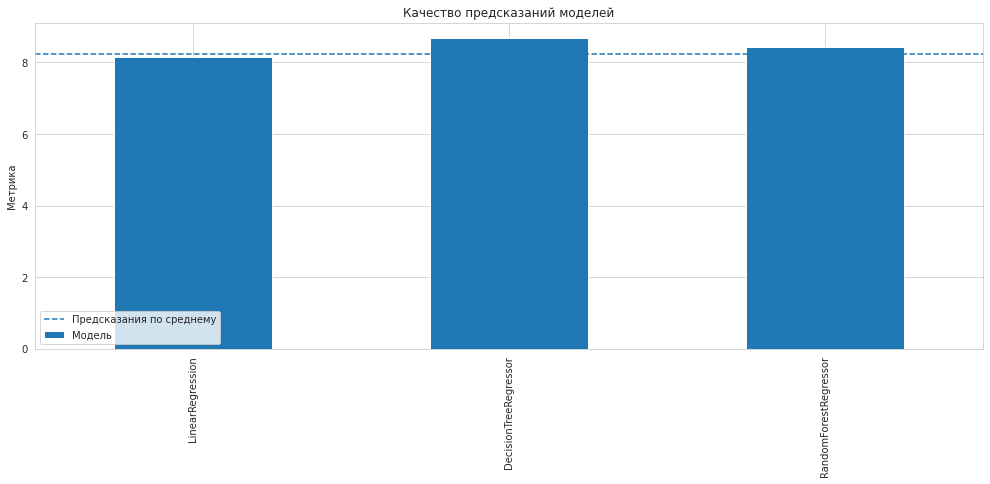

In [85]:
pd.Series(general_table).plot(grid=True,figsize=(17, 6),kind='bar',label = 'Модель')
plt.axhline(total_sMape(mean_rougher, mean_final), xmin=0, xmax=1, linestyle = '--',label = 'Предсказания по среднему')
plt.title('Качество предсказаний моделей')
plt.ylabel('Метрика')
plt.legend()
plt.show()

Вывод:

Лучше всех себя показала LinearRegression,с результатом sMAPE на тестовой выборке 8.16.

---

#### Сравним распределение значения правильных ответов и реальных значений.

In [86]:
predict = LinearRegression.predict(features_test_final)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


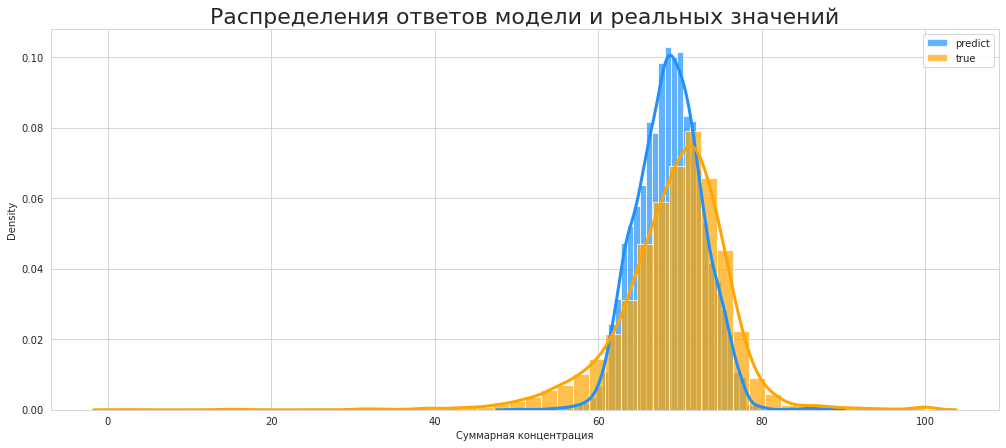

In [87]:
fig = plt.figure(figsize=(17, 7))
sns.set_style('whitegrid')
sns.distplot(predict, color="dodgerblue", label="predict", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(target_test_final, color="orange", label="true", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})

plt.title('Распределения ответов модели и реальных значений', fontsize=22)
plt.xlabel('Суммарная концентрация')
plt.legend()
plt.show()

Проверяет сходство выборок критерием Манна-Уитни.

In [88]:
stat, p = mannwhitneyu(predict, target_test_final, alternative='two-sided')
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Statistics=11403173.000, p-value=0.000
Отвергаем нулевую гипотезу


Вывод:

Распределения выглядят аналогично, но тест Манна-Уитни говорит об обратном. Возможно причина кроется в нулевых значениях.

## Вывод

- **Предобработка:** мы произвели предобработку имеющихся у нас выборок. Обучающую и тестовую выборку очистили от пустых строк, убрали лишние столбцы.

- **Исследование:**  Посмотрели, как меняется концентрация металлов. Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. Исследовали суммарную концентрацию всех веществ на разных стадиях.

- **Обучение модели:** обучили несколько моделей, выбрали лучшую модель.